In [1]:
import pandas as pd 
import numpy as np

# Input data
data = pd.read_csv('../input/train_labels.csv')
sub = pd.read_csv('../input/sample_submission.csv')
path = '../input'
train_path = path + '/train/'

In [2]:
# Identify Outliers 
import os
from scipy import ndimage
from tqdm import tqdm_notebook # display a progress bar 

dark_thres = 10 / 255      # If no pixel reaches this threshold, image is considered too dark 
bright_thres = 245 / 255   # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

for i, idx in tqdm_notebook(enumerate(data['id']), '({} images)'.format(len(data))):
    img_path = os.path.join(train_path, idx)
    imagearray = (ndimage.imread(img_path + '.tif')/255).reshape(-1,3) # Normalized to 0~1
    # is this too dark
    if(imagearray.max() < dark_thres):
        too_dark_idx.append(idx)
    # is this too bright
    if(imagearray.min() > bright_thres):
        too_bright_idx.append(idx)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]


In [3]:
# Remove outliers
data = data.set_index('id')
data = data.drop(labels=too_dark_idx, axis=0)
data = data.drop(labels=too_bright_idx, axis=0)

train_names = data.index.values
train_labels = np.asarray(data['label'].values)
train_dict = {'id':  train_names, 'label': train_labels}
train_data = pd.DataFrame(data=train_dict)

In [4]:
# Import fastai libraries
from fastai import *
from fastai.vision import *
from torchvision.models import * 

In [5]:
# Data augmentation
transforms = get_transforms(do_flip = True, flip_vert = True, max_rotate =5.0, max_zoom =1.1,
                            max_lighting = 0.1, max_warp = 0.1)

In [6]:
# Specify training and test data set
sz=96
data = ImageDataBunch.from_df(path, folder='train', df = train_data, 
                               ds_tfms = transforms, size =sz, suffix ='.tif', test ='test', bs =128)
stats =data.batch_stats()
data.normalize(stats)

ImageDataBunch;

Train: LabelList (176015 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: ../input;

Valid: LabelList (44003 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: ../input;

Test: LabelList (57458 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: ../input

In [7]:
from sklearn.metrics import roc_auc_score

# Define roc-auc metric
def auc_score(y_pred, y_true, tensr = True):
    score = roc_auc_score(y_true, y_pred[:,1])
    if tensr:
        score = tensor(score)
    return score

# Training

In [8]:
# Specify tansfer learning model
arch = densenet169 
learner = cnn_learner(data, arch, pretrained = True, path='.',
                     metrics = [accuracy, auc_score],ps=0.5)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /tmp/.torch/models/densenet169-b2777c0a.pth
57365526it [00:01, 28950536.05it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


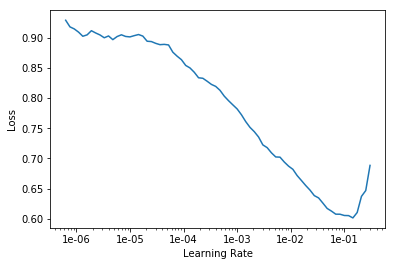

In [9]:
# Find a proper learning rate for training
learner.lr_find()
learner.recorder.plot()

In [10]:
# Training
learner.fit_one_cycle(8, 2e-2)
learner.recorder.plot_lr()
learner.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.207108,0.236676,0.904643,0.961438,09:52
1,0.205216,0.235878,0.908643,0.965014,09:53


In [11]:
# Save the model
learner.save('Densenet169_stage1')

In [12]:
# Predict tumor probability for the validation set
preds, y = learner.TTA(with_loss=False)

In [13]:
# Get validation accuracy
acc = accuracy(preds, y)
print('The validation accuracy is {0} %.'.format(acc))

The validation accuracy is 0.957707405090332 %.


In [14]:
from sklearn.metrics import roc_curve, auc

# Get validation AUC-ROC score
# predicted tumor probability
probs = preds[:,1]

# Compute false positive rate and  true positive rate
fpr, tpr, _ = roc_curve(y, probs)

# Compute ROC-AUC score
roc_auc = auc(fpr, tpr)
print('The ROC-AUC score for the validation set is {}'.format(roc_auc))

The ROC-AUC score for the validation set is 0.989895072105233


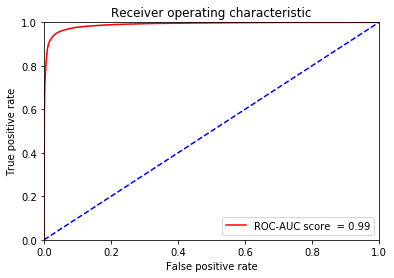

In [15]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC-AUC score  = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_Stage1.jpg')

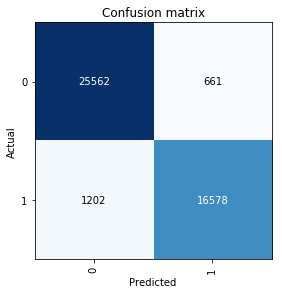

In [16]:
interp = ClassificationInterpretation.from_learner(learner)
# Confusion matrix
interp.plot_confusion_matrix(title='Confusion matrix')

In [17]:
# Predict tumor probabilties for test data sets
preds_test,_=learner.TTA(ds_type=DatasetType.Test)

In [18]:
# Create a submission file 
sub_list = list(sub.id)

pred_list = list(preds_test[:,1])
pred_dict = dict((key, value.item()) for (key, value) 
                 in zip(learner.data.test_ds.items,pred_list))
# Create a new list with the same order as in sample_submission
pred_ordered = [pred_dict[Path('../input/test/' + id + '.tif')] for id in sub_list]
submissions = pd.DataFrame({'id':sub_list,'label':pred_ordered})
submissions.to_csv('sample_submission_densenet169_stage1.csv',
                   header=True, index = False)

# Finetuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


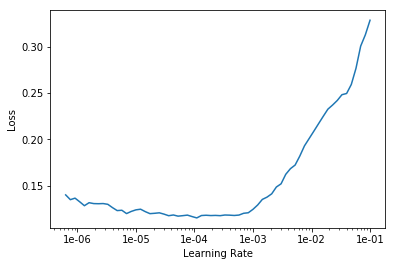

In [19]:
# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [20]:
# finetuning
learner.fit_one_cycle(8,slice(2e-5,1e-4))
learner.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.123122,0.119797,0.957457,0.990377,10:18
1,0.118636,0.131157,0.952412,0.988293,10:16


In [21]:
# Save the model
learner.save('Densenet169_stage2')

In [22]:
# Predict tumor probability for the validation set
preds, y = learner.TTA(with_loss=False)

In [23]:
# Get validation accuracy
acc = accuracy(preds, y)
print('The validation accuracy is {0} %.'.format(acc))

The validation accuracy is 0.9650933146476746 %.


In [24]:
# Get validation AUC-ROC score
# predicted tumor probability
probs = preds[:,1]

# Compute false positive rate and  true positive rate
fpr, tpr, _ = roc_curve(y, probs)

# Compute ROC-AUC score
roc_auc = auc(fpr, tpr)
print('The ROC-AUC score for the validation set is {}'.format(roc_auc))

The ROC-AUC score for the validation set is 0.9926487266542775


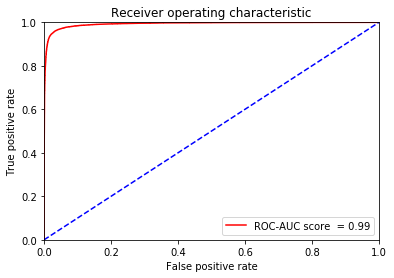

In [25]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC-AUC score  = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_Stage2.jpg')

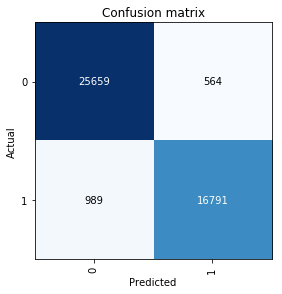

In [26]:
interp = ClassificationInterpretation.from_learner(learner)
# Confusion matrix
interp.plot_confusion_matrix(title='Confusion matrix')

In [27]:
# Predict tumor probabilties for test data sets
preds_test,_=learner.TTA(ds_type=DatasetType.Test)

In [28]:
# Create a submission file 

sub_list = list(sub.id)
pred_list = list(preds_test[:,1])
pred_dict = dict((key, value.item()) for (key, value) 
                 in zip(learner.data.test_ds.items,pred_list))
# Create a new list with the same order as in sample_submission
pred_ordered = [pred_dict[Path('../input/test/' + id + '.tif')] for id in sub_list]
submissions = pd.DataFrame({'id':sub_list,'label':pred_ordered})
submissions.to_csv('sample_submission_densenet169_stage2.csv',
                   header=True, index = False)

# Free-Form Visualization

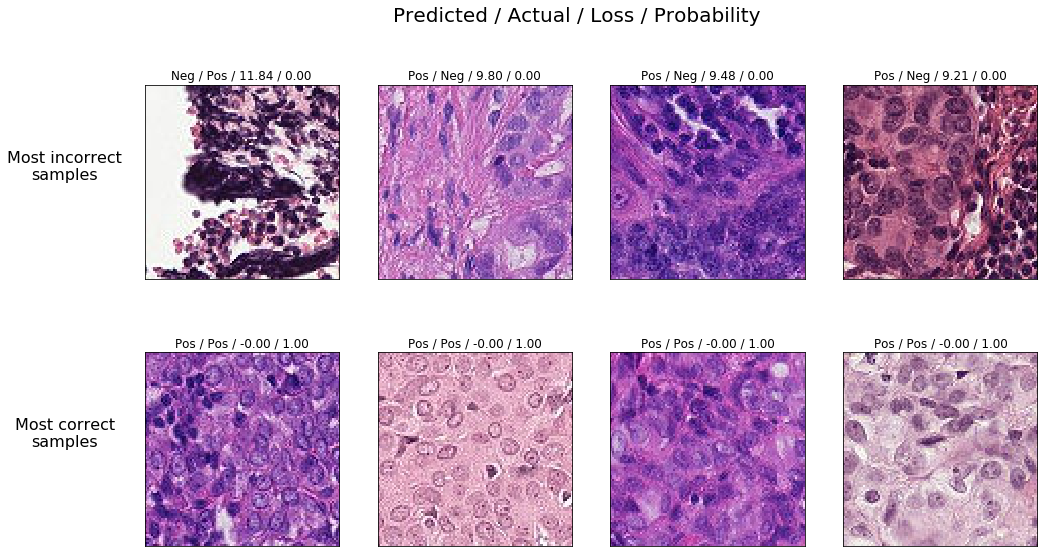

In [29]:
# Visualize the most correct and incorrect predictions

# top losses will return all validation losses and indexes sorted by the largest first
val_loss,val_idx = interp.top_losses()

classes=['Neg','Pos']

fig, ax = plt.subplots(2,4, figsize=(16,9))
fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
for i in range(4):
    idx = val_idx[i]
    imag,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
    cl = int(cl)
    imag = image2np(imag.data)
    ax[0,i].imshow(imag)
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
ax[0,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)    

for i in range(4):
    idx = val_idx[len(val_idx) - i - 1]
    imag,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
    cl = int(cl)
    imag = image2np(imag.data)
    ax[1,i].imshow(imag)
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
ax[1,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)
plt.savefig('Most_Incorrect_and_Correct_Predictions.jpg')